In [ ]:
import os
import cv2
import numpy as np
import keras
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, UpSampling2D
from keras.callbacks import TensorBoard

In [ ]:
(x_trn, y_trn), (x_tst, y_tst) = cifar100.load_data(label_mode='fine')

169001437/169001437 [==============================] - 6s 0us/step


In [ ]:
# Фильтрация изображений по классам "животных, семейства кошачьих"
# индекс класса bed - 5, chair - 20, couch - 25, table - 84, wardrobe - 94


x_image_bed_trn = x_trn[y_trn.flatten() == 5]
x_image_chair_trn = x_trn[y_trn.flatten() == 20]
x_image_couch_trn = x_trn[y_trn.flatten() == 25]
x_image_table_trn = x_trn[y_trn.flatten() == 84]
x_image_wardrobe_trn = x_trn[y_trn.flatten() == 94]


x_image_bed_tst = x_tst[y_tst.flatten() == 5]
x_image_chair_tst = x_tst[y_tst.flatten() == 20]
x_image_couch_tst = x_tst[y_tst.flatten() == 25]
x_image_table_tst = x_tst[y_tst.flatten() == 84]
x_image_wardrobe_tst = x_tst[y_tst.flatten() == 94]

In [ ]:
def create_x(img1, img2, img3, img4, img5):
  x_image = np.append(img1, img2, axis=0)
  x_image = np.append(x_image, img3, axis=0)
  x_image = np.append(x_image, img4, axis=0)
  x_image = np.append(x_image, img5, axis=0)
  return x_image

In [ ]:
x_image_trn = create_x(x_image_bed_trn, x_image_chair_trn, x_image_couch_trn, x_image_table_trn, x_image_wardrobe_trn)
x_image_tst = create_x(x_image_bed_tst, x_image_chair_tst, x_image_couch_tst, x_image_table_tst, x_image_wardrobe_tst)

In [ ]:
def sp_noise(image,prob):

    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [ ]:
Xtrain = []
Ytrain = x_image_trn
Xtest = []
Ytest = x_image_tst
for fil in x_image_trn:
    #fil = cv2.blur(fil,(5,5))
    #fil = cv2.resize(fil,(,56))
    fil = sp_noise(fil,0.05)
    fil.shape = (32,32,3)

    Xtrain.append(fil)
for fil in x_image_tst:
    #fil = cv2.blur(fil,(5,5))
    fil = sp_noise(fil,0.05)
    #fil = cv2.resize(fil,(56,56))
    fil.shape = (32,32,3)
    Xtest.append(fil)
images=np.array(Ytrain)
images = images.astype(np.float32)
images = images/255
noisy_images=np.array(Xtrain)
noisy_images = noisy_images.astype(np.float32)
noisy_images = noisy_images/255

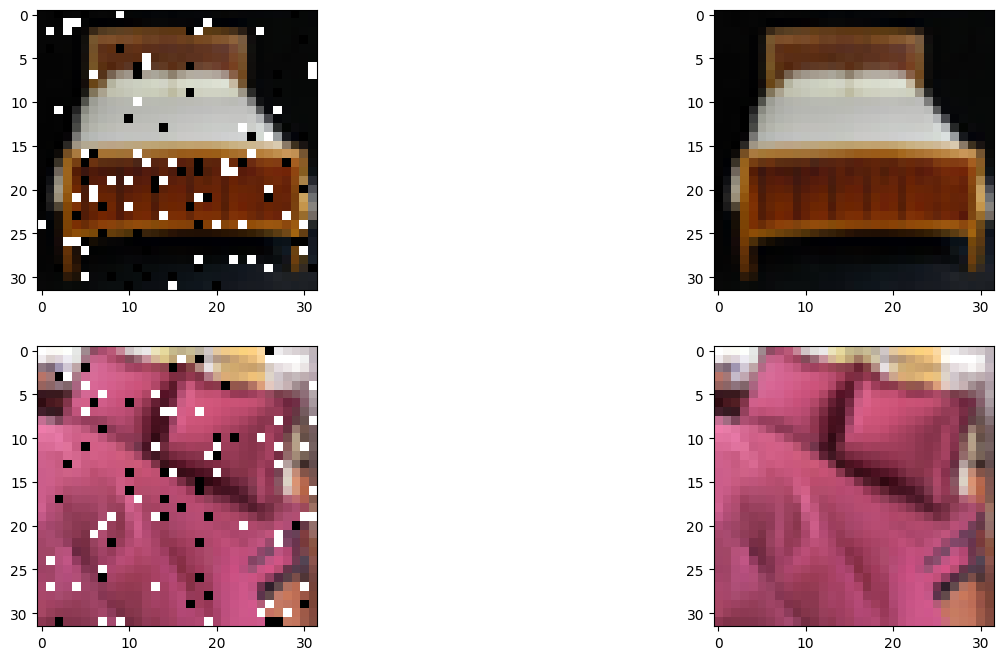

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (16, 8))

axs[0][0].imshow(Xtrain[0])
axs[0][1].imshow(Ytrain[0])
axs[1][0].imshow(Xtrain[1])
axs[1][1].imshow(Ytrain[1])

In [ ]:
input_img = keras.Input(shape=(32, 32, 3))
#encoder
conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)

#decoder
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
up1 = UpSampling2D((2,2))(conv4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2,2))(conv5)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 8, 8, 64)          7379

In [ ]:
print(len(Xtrain))
print(len(Ytrain))

2500
2500


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(noisy_images, images, test_size=0.2, random_state=42)

In [ ]:
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,batch_size=75)

Epoch 1/20
27/27 [==============================] - 4s 36ms/step - loss: 0.6473 - accuracy: 0.6897 - val_loss: 0.5908 - val_accuracy: 0.7499
Epoch 2/20
27/27 [==============================] - 1s 20ms/step - loss: 0.5790 - accuracy: 0.7422 - val_loss: 0.5570 - val_accuracy: 0.7547
Epoch 3/20
27/27 [==============================] - 1s 21ms/step - loss: 0.5493 - accuracy: 0.7303 - val_loss: 0.5356 - val_accuracy: 0.7770
Epoch 4/20
27/27 [==============================] - 1s 21ms/step - loss: 0.5392 - accuracy: 0.7518 - val_loss: 0.5327 - val_accuracy: 0.7476
Epoch 5/20
27/27 [==============================] - 1s 20ms/step - loss: 0.5333 - accuracy: 0.7630 - val_loss: 0.5269 - val_accuracy: 0.7690
Epoch 6/20
27/27 [==============================] - 1s 21ms/step - loss: 0.5289 - accuracy: 0.7579 - val_loss: 0.5235 - val_accuracy: 0.7532
Epoch 7/20
27/27 [==============================] - 1s 20ms/step - loss: 0.5260 - accuracy: 0.7623 - val_loss: 0.5213 - val_accuracy: 0.7927
Epoch 8/20
27

In [ ]:
decoded_imgs = autoencoder.predict(X_train)

63/63 [==============================] - 0s 4ms/step


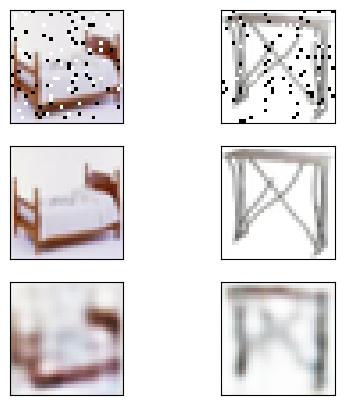

In [ ]:
n = 2
plt.figure(figsize=(5, 5))

for i in range(n):
	# оригинальные изображения
	ax = plt.subplot(3, n, i + 1)
	plt.imshow((X_train[i+5]))
	plt.gray()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

  # зашумленные изображения
	ax = plt.subplot(3, n, i + 1 + n)
	plt.imshow(y_train[i+5])
	plt.gray()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

	# восстановленные изображения автоэнкодером
	ax = plt.subplot(3, n, i + 1 + 2*n)
	plt.imshow(np.array(decoded_imgs[i+5]))
	plt.gray()
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
plt.show()